In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn import metrics
import re

# pip install -U imbalanced-learn
# pip install xgboost

## DATASET 1: MICROCALCIFICATION

In [2]:
df = pd.read_csv("microcalcification.csv")

In [3]:
df.head(5)

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [4]:
df.shape

(11183, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                11183 non-null  float64
 1   Grey Level          11183 non-null  float64
 2   Gradient Strength   11183 non-null  float64
 3   Noise Fluctuation   11183 non-null  float64
 4   Contrast            11183 non-null  float64
 5   Shape Descriptor    11183 non-null  float64
 6   Microcalcification  11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


In [6]:
# Alter Microcalsification class as int and 0-1 

df['Microcalcification'] = df['Microcalcification'].replace("'-1'", 0)
df['Microcalcification'] = df['Microcalcification'].replace("'1'", 1)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,11183.0,1.096536e-10,1.000000,-0.784415,-0.784415,-0.108577,0.313949,31.508443
Grey Level,11183.0,1.297595e-09,1.000000,-0.470195,-0.470195,-0.394994,-0.076495,5.085849
Gradient Strength,11183.0,5.698113e-10,1.000000,-0.591631,-0.591631,-0.230979,0.219837,29.477769
Noise Fluctuation,11183.0,-2.435706e-09,1.000000,-0.859553,-0.859553,-0.859553,0.820208,9.591164
Contrast,11183.0,-1.120680e-09,1.000000,-0.377866,-0.377866,-0.377866,-0.377866,23.617122
Shape Descriptor,11183.0,1.459483e-09,1.000000,-0.945723,-0.945723,-0.945723,1.016613,1.949027
Microcalcification,11183.0,2.324958e-02,0.150702,0.000000,0.000000,0.000000,0.000000,1.000000


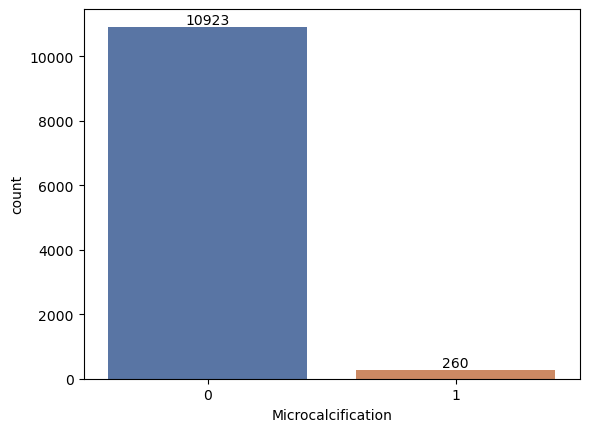

In [8]:
# Target Variable Class Counts

class_counts = df["Microcalcification"].value_counts()             
ax = sns.countplot(x="Microcalcification", data=df, palette="deep") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

## DATA CLEANING

In [9]:
# Missing Value Check

df.isnull().sum()

Area                  0
Grey Level            0
Gradient Strength     0
Noise Fluctuation     0
Contrast              0
Shape Descriptor      0
Microcalcification    0
dtype: int64

In [10]:
# Duplicated Value Check

df.duplicated().value_counts()

False    7849
True     3334
Name: count, dtype: int64

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
# Outliers Check 

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    '''
    Outlier Thresholds function define lower and upper limits to detect outlier values
    in a given DataFrame. Quartile1 (q1) and Quartile3(q2) can be changed by the user.
    It returns lower and upper limits based on the interquartile method (IQR).
    '''
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name): 
    '''
    Check Outlier function detects outlier values in a given DataFrame.
    It shows True if there are outlier values in a column, otherwise not.
    '''
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in df.columns:
    print(col, check_outlier(df, col))

Area True
Grey Level False
Gradient Strength True
Noise Fluctuation True
Contrast True
Shape Descriptor False
Microcalcification True


In [13]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df = dataframe[(dataframe[col_name] >= low_limit) & (dataframe[col_name] <= up_limit)]
    return df

remove_outlier(df, "Area")
remove_outlier(df, "Gradient Strength")
remove_outlier(df, "Noise Fluctuation")
remove_outlier(df, "Contrast")
remove_outlier(df, "Microcalcification")

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0
...,...,...,...,...,...,...,...
11147,0.436328,-0.386147,-0.276061,0.840461,1.097551,1.037943,0
11148,-0.204956,-0.359605,0.129673,-0.859553,-0.377866,-0.945723,0
11150,-0.435486,-0.425959,1.932936,-0.128745,0.108803,1.028801,0
11154,0.151934,-0.213626,-0.005571,0.423158,-0.377866,1.101932,0


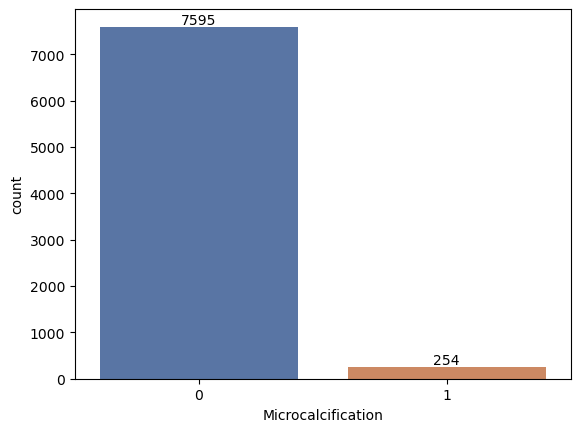

In [14]:
# Target Variable Class Counts

class_counts = df["Microcalcification"].value_counts()             
ax = sns.countplot(x="Microcalcification", data=df, palette="deep") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

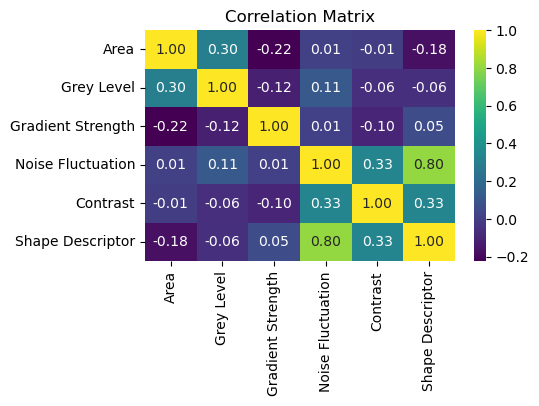

In [15]:
corr = df.iloc[:, :-1].corr()

# Heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

C:\Users\Hilal\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


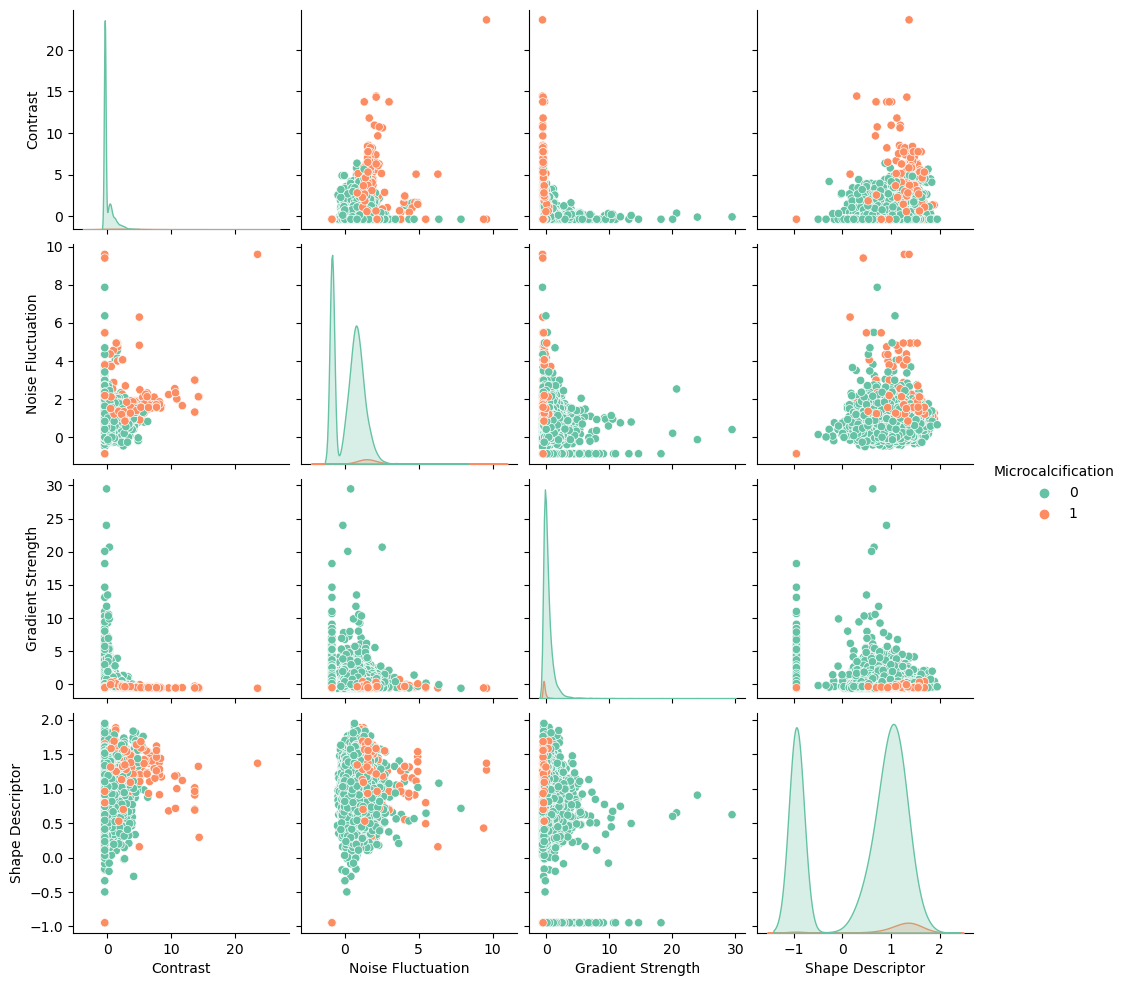

In [16]:
cols=["Contrast","Noise Fluctuation","Gradient Strength","Shape Descriptor","Microcalcification"]

sns.pairplot(df[cols],hue="Microcalcification", palette="Set2");

In [17]:
# Saving clean df to csv file

df.to_csv('microcalcification_cleaned.csv')  

## DATA PREPARATION 

## Over Sampling &  Train-Test Split


In [18]:
X = df.iloc[:, 0:5]  # independent variables
y = df["Microcalcification"]  # target variable

In [19]:
oversample = RandomOverSampler(sampling_strategy=0.3)
X_over, y_over = oversample.fit_resample(X, y)

In [20]:
print(Counter(y_over))

Counter({0: 7595, 1: 2278})


In [21]:
# Splitting data 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, 
                                                    test_size=0.3, random_state=123)

# Size of train and test data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6911, 5)
X_test shape: (2962, 5)
y_train shape: (6911,)
y_test shape: (2962,)


In [22]:
from sklearn.preprocessing import RobustScaler

rb = RobustScaler()

X_train_scaled = rb.fit_transform(X_train)
X_test_scaled = rb.fit_transform(X_test)

## LOGISTIC REGRESSION

In [23]:
log_model = LogisticRegression().fit(X_train_scaled, y_train)           

log_model.intercept_             
log_model.coef_                  


array([[ 0.20560718, -0.5518627 , -1.15105542,  2.59637774,  0.92759238]])

In [24]:
# Prediction
y_pred = log_model.predict(X_test_scaled)        

y_pred[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [25]:
# Cross validation method to explain success of model
cv_results_log = cross_validate(log_model,
                            X_train_scaled, y_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_log

{'fit_time': array([0.01400304, 0.02499437, 0.0247972 , 0.02200651, 0.0220499 ]),
 'score_time': array([0.01904607, 0.0309999 , 0.02600074, 0.0239985 , 0.0250833 ]),
 'test_accuracy': array([0.88430947, 0.90882779, 0.91099855, 0.9081042 , 0.91678726]),
 'train_accuracy': array([0.90991317, 0.90468439, 0.90504612, 0.90613131, 0.90341834]),
 'test_precision': array([0.80754717, 0.87452471, 0.88416988, 0.88844622, 0.89056604]),
 'train_precision': array([0.8784689 , 0.86564299, 0.86743516, 0.86819484, 0.86486486]),
 'test_recall': array([0.6625387 , 0.7120743 , 0.71118012, 0.69254658, 0.73291925]),
 'train_recall': array([0.71217998, 0.69976726, 0.7       , 0.70465116, 0.69457364]),
 'test_f1': array([0.72789116, 0.78498294, 0.78829604, 0.77835951, 0.80408859]),
 'train_f1': array([0.78663239, 0.77391677, 0.77477477, 0.77792041, 0.77042132]),
 'test_roc_auc': array([0.91459489, 0.93370111, 0.93448377, 0.91913454, 0.93264971]),
 'train_roc_auc': array([0.93211252, 0.92615894, 0.92624193, 0

In [26]:
report_log = metrics.classification_report(y_test, y_pred)
print(report_log)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2296
           1       0.84      0.75      0.79       666

    accuracy                           0.91      2962
   macro avg       0.89      0.85      0.87      2962
weighted avg       0.91      0.91      0.91      2962



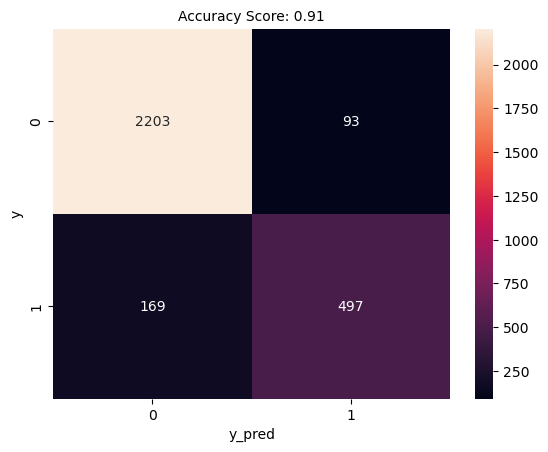

In [27]:
# Confusion Matrix

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

## XGBOOST CLASSIFIER

In [28]:
xgbClass = XGBClassifier()
xgb_model = xgbClass.fit(X_train_scaled, y_train)

In [29]:
#Predict the response for test dataset
y_pred = xgb_model.predict(X_test_scaled)
y_pred[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [30]:
# Cross validation method to explain success of model
cv_results_xgb = cross_validate(xgb_model,
                            X_train_scaled, y_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_xgb


{'fit_time': array([0.16594124, 0.19106221, 0.18693733, 0.18819451, 0.17372799]),
 'score_time': array([0.04119563, 0.04438281, 0.04637313, 0.04457855, 0.04547024]),
 'test_accuracy': array([0.98047722, 0.98625181, 0.98625181, 0.99204052, 0.9934877 ]),
 'train_accuracy': array([0.99963821, 0.99963827, 0.99981914, 0.99963827, 0.99981914]),
 'test_precision': array([0.93786982, 0.94970414, 0.95495495, 0.96696697, 0.97280967]),
 'train_precision': array([0.9992242 , 1.        , 1.        , 0.99845201, 1.        ]),
 'test_recall': array([0.98142415, 0.99380805, 0.98757764, 1.        , 1.        ]),
 'train_recall': array([0.9992242 , 0.99844841, 0.99922481, 1.        , 0.99922481]),
 'test_f1': array([0.9591528 , 0.97125567, 0.97099237, 0.98320611, 0.98621746]),
 'train_f1': array([0.9992242 , 0.9992236 , 0.99961225, 0.99922541, 0.99961225]),
 'test_roc_auc': array([0.99707781, 0.99960825, 0.99747158, 0.99968944, 0.99929392]),
 'train_roc_auc': array([0.99999716, 0.99999909, 1.        , 0

In [31]:
report_xgb = metrics.classification_report(y_test, y_pred)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2296
           1       0.93      0.85      0.89       666

    accuracy                           0.95      2962
   macro avg       0.94      0.92      0.93      2962
weighted avg       0.95      0.95      0.95      2962



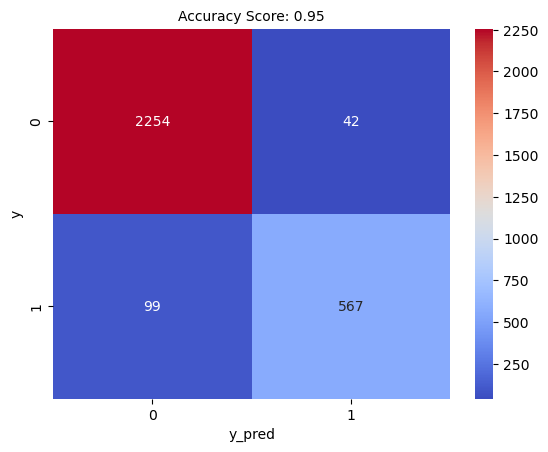

In [32]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

## MODELS EVALUATION METRICS FOR DATASET 1 WITH BAR GRAPH

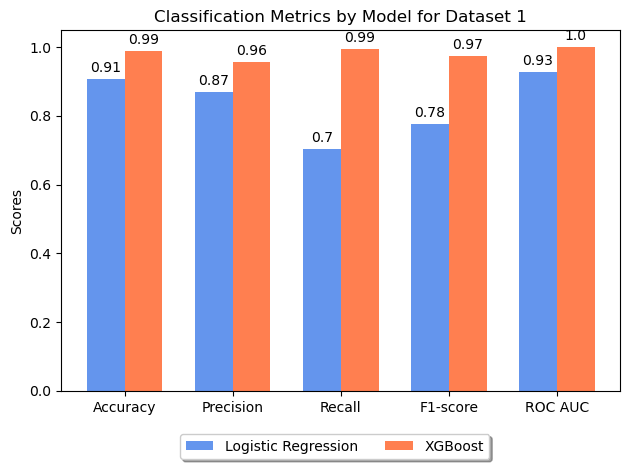

In [33]:
# Logistic Regression Metrics and Xgboost Evaluation Metrics
log_metrics = np.array([cv_results_log['test_accuracy'].mean(),
                        cv_results_log['test_precision'].mean(),
                        cv_results_log['test_recall'].mean(),
                        cv_results_log['test_f1'].mean(),
                        cv_results_log['test_roc_auc'].mean()])

xgb_metrics = np.array([cv_results_xgb['test_accuracy'].mean(),
                        cv_results_xgb['test_precision'].mean(),
                        cv_results_xgb['test_recall'].mean(),
                        cv_results_xgb['test_f1'].mean(),
                        cv_results_xgb['test_roc_auc'].mean()])

# Evaluation Metric Names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

# Colors
log_color = 'cornflowerblue'
xgb_color = 'coral'

# Bar Graph
x = np.arange(len(metric_names))  
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, log_metrics, width, label='Logistic Regression', color=log_color)
bars2 = ax.bar(x + width/2, xgb_metrics, width, label='XGBoost', color=xgb_color)

# Labels
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Model for Dataset 1')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Legend Location
ax.legend(loc='upper left', bbox_to_anchor=(0.2, -0.1), shadow=True, ncol=2)

# To add metric results to all bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

## DATASET 2: DIABETES HEALTH INDICATORS

In [34]:
df2 = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

In [35]:
df2.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [36]:
df2.shape

(253680, 22)

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [38]:
df2["Diabetes_012"].value_counts()     # 0: no diabetes, 1: prediabetes, 2: diabetes.

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [39]:
# Changing diabet class 2 diabetes as 1

df2["Diabetes_012"] = df2["Diabetes_012"].replace(2, 1)

In [40]:
df2["Diabetes_012"].value_counts() 

Diabetes_012
0.0    213703
1.0     39977
Name: count, dtype: int64

In [41]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,253680.0,0.157588,0.364355,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


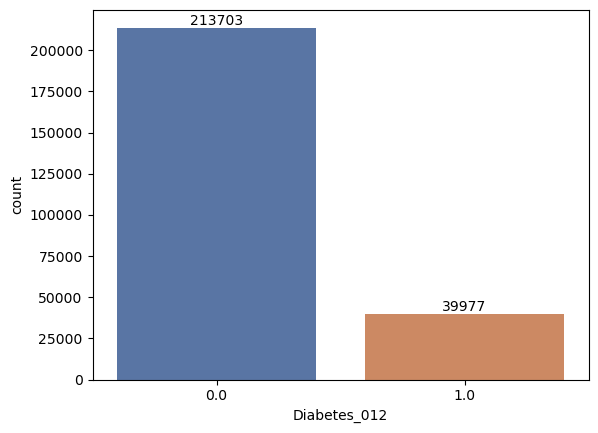

In [42]:
# Target Variable Class Counts

class_counts = df2["Diabetes_012"].value_counts()             
ax = sns.countplot(x="Diabetes_012", data=df2, palette="deep") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

## DATA CLEANING

In [43]:
# Missing Value Check

df2.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [44]:
# Duplicated Value Check

df2.duplicated().value_counts()

False    229712
True      23968
Name: count, dtype: int64

In [45]:
df2.drop_duplicates(inplace=True)

In [46]:
# Outliers Check 

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    '''
    Outlier Thresholds function define lower and upper limits to detect outlier values
    in a given DataFrame. Quartile1 (q1) and Quartile3(q2) can be changed by the user.
    It returns lower and upper limits based on the interquartile method (IQR).
    '''
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name): 
    '''
    Check Outlier function detects outlier values in a given DataFrame.
    It shows True if there are outlier values in a column, otherwise not.
    '''
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in df2.columns:
    print(col, check_outlier(df2, col))

Diabetes_012 False
HighBP False
HighChol False
CholCheck True
BMI True
Smoker False
Stroke True
HeartDiseaseorAttack False
PhysActivity False
Fruits False
Veggies False
HvyAlcoholConsump False
AnyHealthcare False
NoDocbcCost False
GenHlth False
MentHlth False
PhysHlth False
DiffWalk False
Sex False
Age False
Education False
Income False


In [47]:
# Replacing the outliers with up and low value

def replace_with_thresholds(dataframe, variable):
    '''
    Replace_with_thresholds function replace the outliers with up and low value.
    '''
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

    
replace_with_thresholds(df2, "CholCheck")
replace_with_thresholds(df2, "BMI")
replace_with_thresholds(df2, "Stroke")

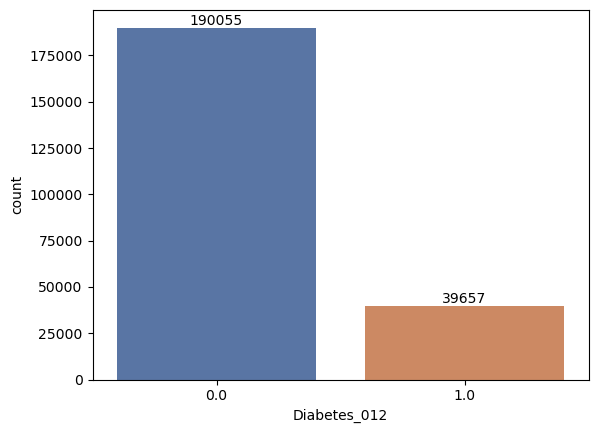

In [48]:
# Target Variable Class Counts

class_counts = df2["Diabetes_012"].value_counts()             
ax = sns.countplot(x="Diabetes_012", data=df2, palette="deep") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

In [49]:
df2["Age"].value_counts().sort_index()

Age
1.0      5512
2.0      7068
3.0     10025
4.0     12234
5.0     14050
6.0     17299
7.0     23138
8.0     27297
9.0     29715
10.0    29147
11.0    22034
12.0    15386
13.0    16807
Name: count, dtype: int64

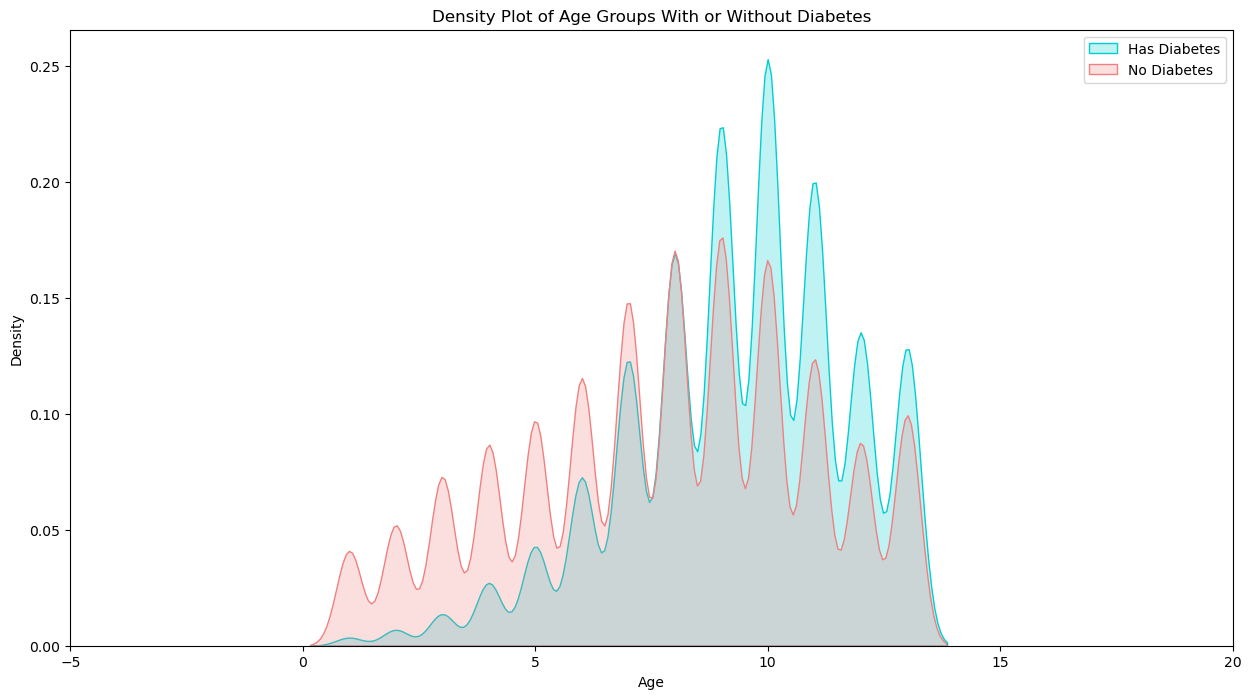

In [50]:
# Density Plot of Age Groups With or Without Diabetes

plt.figure(figsize=(15, 8))
ax = sns.kdeplot(df2["Age"][df2.Diabetes_012 == 1], color="darkturquoise", fill=True)
sns.kdeplot(df2["Age"][df2.Diabetes_012 == 0], color="lightcoral", fill=True)
plt.legend(['Has Diabetes', 'No Diabetes'])
plt.title('Density Plot of Age Groups With or Without Diabetes')
ax.set(xlabel='Age')
plt.xlim(-5, 20)
plt.show()

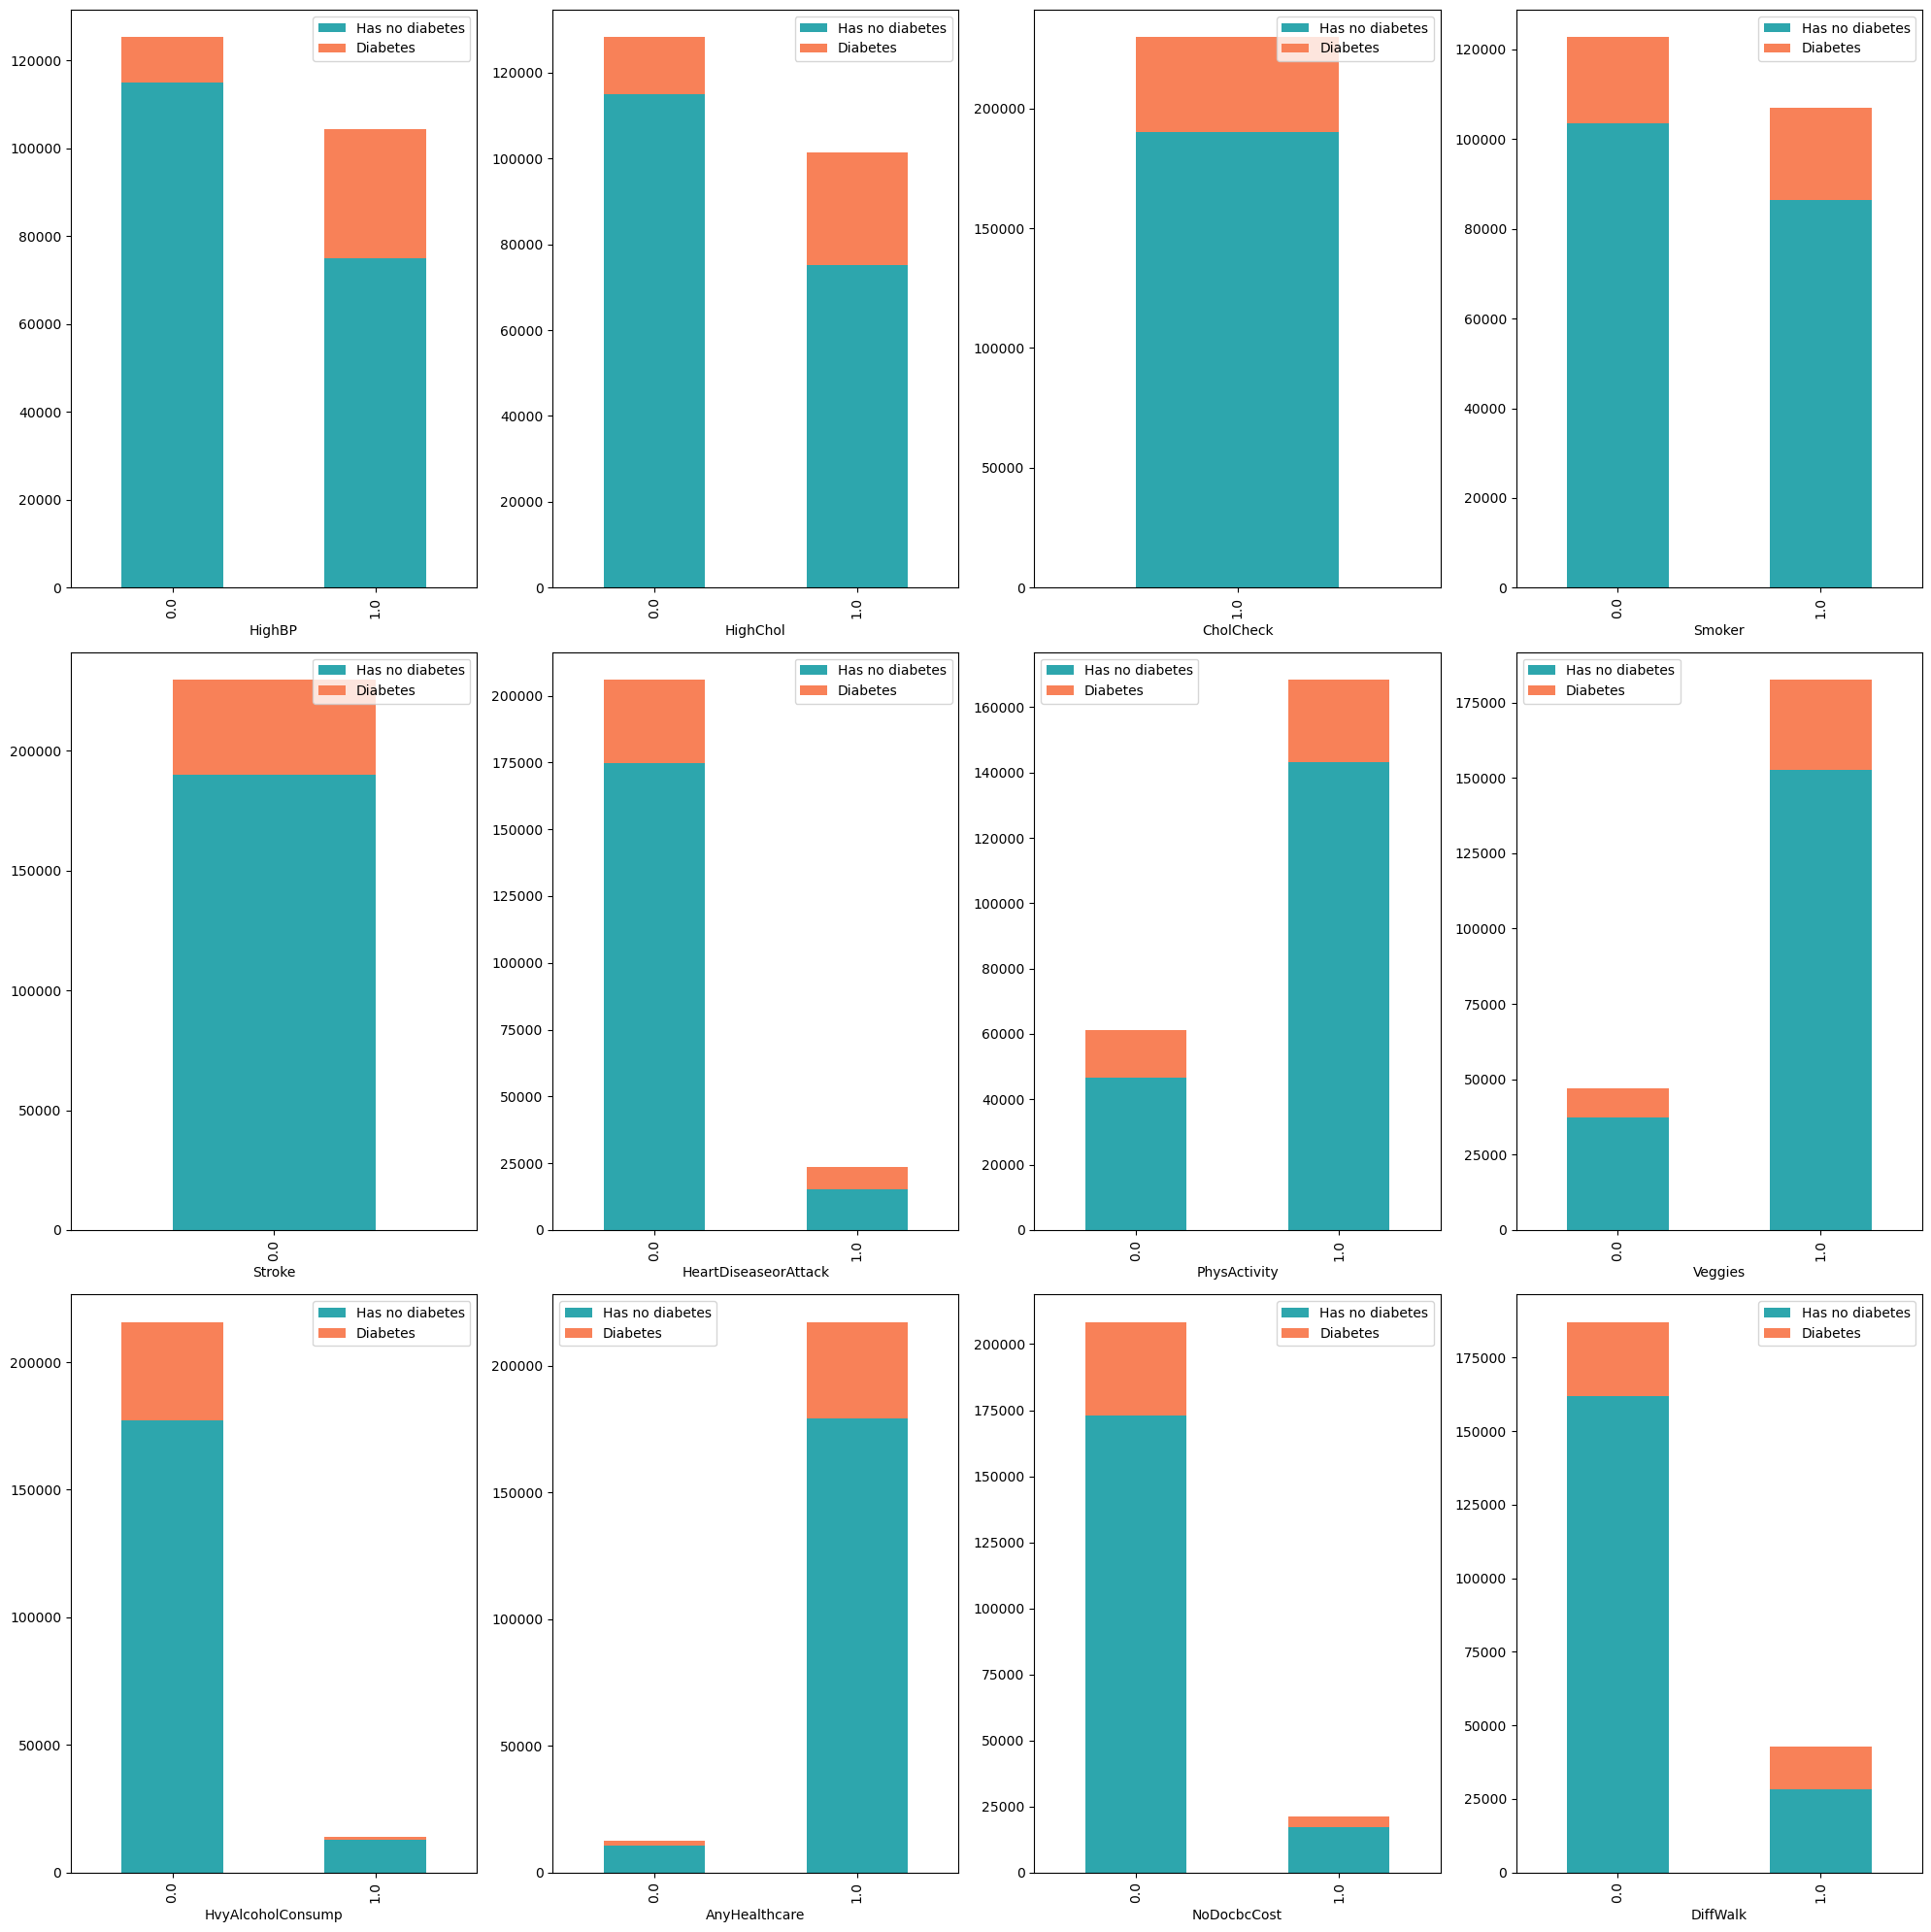

In [51]:
my_cols = ["HighBP", "HighChol", "CholCheck", "Smoker",
        "Stroke", "HeartDiseaseorAttack", "PhysActivity", "Veggies",
        "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "DiffWalk"]

def plot_pivot(df, columns):
    _df_plot = df.groupby([columns, 'Diabetes_012']).size() \
    .reset_index().pivot(columns='Diabetes_012', index=columns, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()

c = len(my_cols)

for i in range(c):
    plot_data = plot_pivot(df2, my_cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=["#2da6ad", '#F88158'])
    axe[i].set_xlabel(my_cols[i])
    # Customize legend labels
    axe[i].legend(['Has no diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

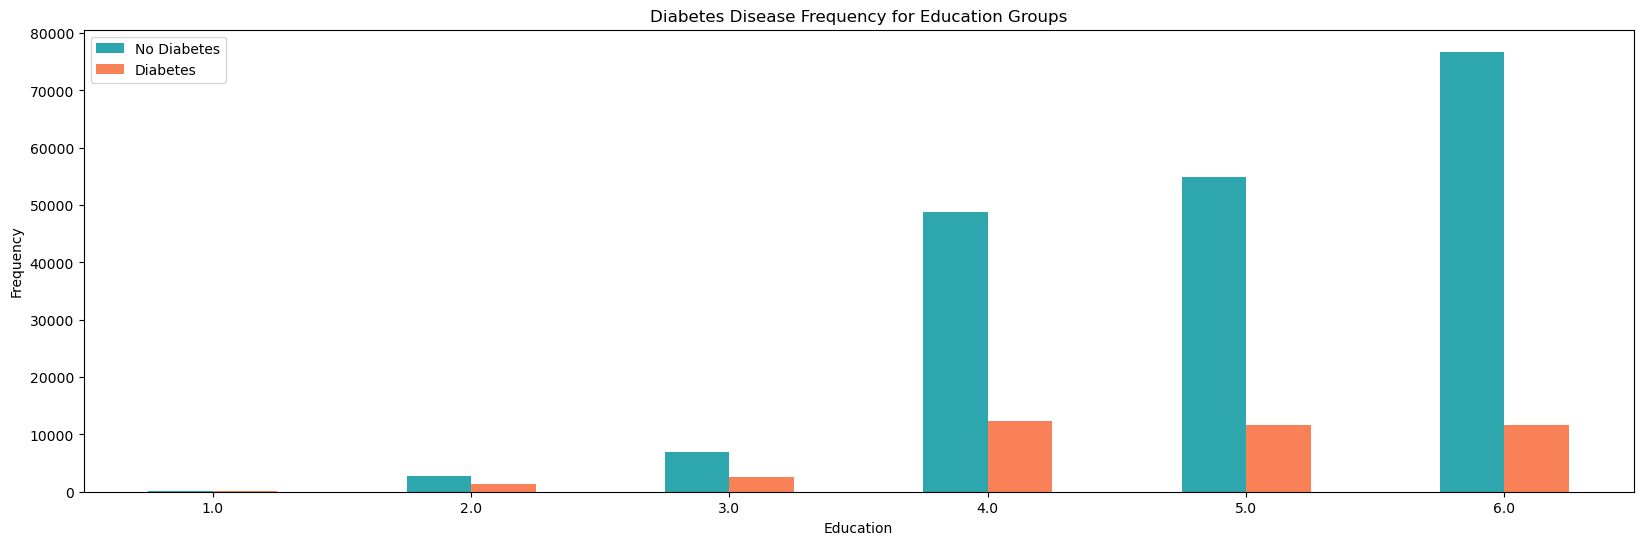

In [52]:
pd.crosstab(df2.Education,df2.Diabetes_012).plot(kind="bar",figsize=(20,6),color=["#2da6ad", '#F88158'])
plt.title('Diabetes Disease Frequency for Education Groups')
plt.xlabel('Education')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

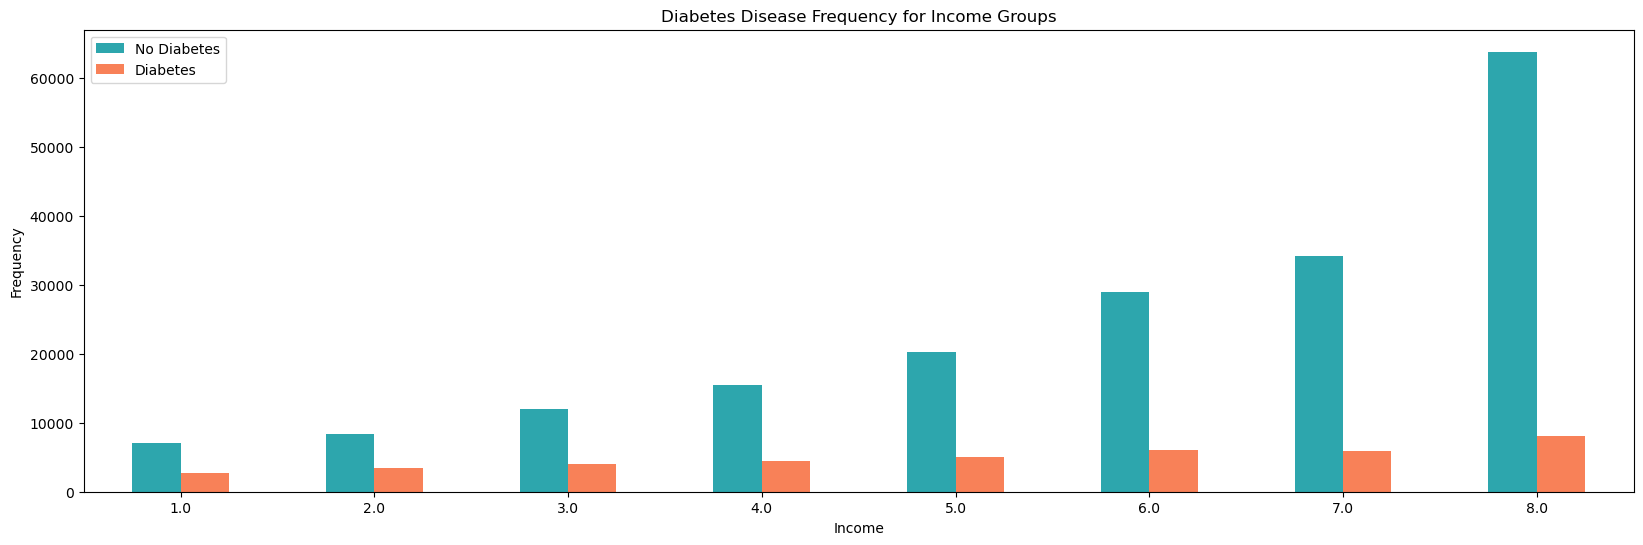

In [53]:
pd.crosstab(df2.Income,df2.Diabetes_012).plot(kind="bar",figsize=(20,6),color=["#2da6ad", '#F88158'])
plt.title('Diabetes Disease Frequency for Income Groups')
plt.xlabel('Income')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

## FEATURE ENGINEERING

In [54]:
#BMI level
#These levels are determined according to the
# accepted Body mass indicator (BMI) values.    #     https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html
df2.loc[(df2['BMI'] < 18),'new_BMI'] = 'Underweight'
df2.loc[(df2['BMI'] >= 19) & (df2['BMI'] < 25), 'new_BMI'] = 'Healthy_Weight'
df2.loc[(df2['BMI'] >= 26) & (df2['BMI'] < 30),'new_BMI'] = 'Overweight'
df2.loc[(df2['BMI'] >= 31),'new_BMI'] = 'Obesity'


#Age Level                                      #    https://www.cdc.gov/brfss/annual_data/2015/pdf/2015_calculated_variables_version4.pdf
df2.loc[(df2['Age'] <= 1) ,'new_age'] = 'Young'
df2.loc[(df2['Age'] >= 2) & (df2['Age'] <= 7), 'new_age'] = 'Mature'
df2.loc[(df2['Age'] >= 8), 'new_age'] = 'Older'

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229712 entries, 0 to 253679
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          229712 non-null  float64
 1   HighBP                229712 non-null  float64
 2   HighChol              229712 non-null  float64
 3   CholCheck             229712 non-null  float64
 4   BMI                   229712 non-null  float64
 5   Smoker                229712 non-null  float64
 6   Stroke                229712 non-null  float64
 7   HeartDiseaseorAttack  229712 non-null  float64
 8   PhysActivity          229712 non-null  float64
 9   Fruits                229712 non-null  float64
 10  Veggies               229712 non-null  float64
 11  HvyAlcoholConsump     229712 non-null  float64
 12  AnyHealthcare         229712 non-null  float64
 13  NoDocbcCost           229712 non-null  float64
 14  GenHlth               229712 non-null  float64
 15  MentH

In [56]:
#One-Hot Encoding

categorical_cols = df2[["new_BMI","new_age"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    dataframe = dataframe.astype(int)
    return dataframe

#ohe_cols 
ohe_cols = ['new_BMI',
 'new_age']


df2 = one_hot_encoder(df2, ohe_cols)
df2.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Age,Education,Income,new_BMI_Healthy_Weight,new_BMI_Obesity,new_BMI_Overweight,new_BMI_Underweight,new_age_Mature,new_age_Older,new_age_Young
0,0,1,1,1,40,1,0,0,0,0,...,9,4,3,0,1,0,0,0,1,0
1,0,0,0,1,25,1,0,0,1,0,...,7,6,1,0,0,0,0,1,0,0
2,0,1,1,1,28,0,0,0,0,1,...,9,4,8,0,0,1,0,0,1,0
3,0,1,0,1,27,0,0,0,1,1,...,11,3,6,0,0,1,0,0,1,0
4,0,1,1,1,24,0,0,0,1,1,...,11,5,4,1,0,0,0,0,1,0


In [57]:
# Saving clean df2 to csv file

df2.to_csv('diabetes_012_health_indicators_BRFSS2015_cleaned.csv')  

## DATA PREPARATION 

## Over Sampling &  Train-Test Split

In [58]:
X2 = df2.iloc[:, 1:]  # independent variables
y2 = df2["Diabetes_012"]  # target variable

In [59]:
oversample = RandomOverSampler(sampling_strategy=0.7)
X2_over, y2_over = oversample.fit_resample(X2, y2)

In [60]:
print(Counter(y2_over))

Counter({0: 190055, 1: 133038})


In [61]:
# Splitting data 70% training, 30% testing
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_over, y2_over, 
                                                    test_size=0.3, random_state=123)

# Size of train and test data
print("X2_train shape:", X2_train.shape)
print("X2_test shape:", X2_test.shape)
print("y2_train shape:", y2_train.shape)
print("y2_test shape:", y2_test.shape)

X2_train shape: (226165, 28)
X2_test shape: (96928, 28)
y2_train shape: (226165,)
y2_test shape: (96928,)


In [62]:
from sklearn.preprocessing import RobustScaler

rb = RobustScaler()

X2_train_scaled = rb.fit_transform(X2_train)
X2_test_scaled = rb.fit_transform(X2_test)

## LOGISTIC REGRESSION

In [63]:
log_model_2 = LogisticRegression(solver='liblinear').fit(X2_train_scaled, y2_train)           

log_model_2.intercept_             
log_model_2.coef_                  


array([[ 0.65252625,  0.57326497,  0.        ,  0.31721995, -0.0370137 ,
         0.        ,  0.21796452, -0.01019735,  0.00196164, -0.02265452,
        -0.68983105,  0.12842082,  0.03899131,  1.02643089, -0.00593171,
        -0.03042214,  0.10191554,  0.24507489,  0.45330607, -0.06851525,
        -0.20431255, -0.37150198,  0.30443235,  0.0077228 , -0.59142011,
         0.18122419,  0.37621337, -0.55743757]])

In [64]:
# Prediction
y2_pred= log_model_2.predict(X2_test_scaled)        

y2_pred[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [65]:
# Cross validation method to explain success of model

cv_results_log_2 = cross_validate(log_model_2,
                            X2_train_scaled, y2_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_log_2

{'fit_time': array([1.86110926, 1.80303574, 1.32875538, 1.14392662, 1.16678357]),
 'score_time': array([0.15700436, 0.1405468 , 0.06928968, 0.07219005, 0.08801174]),
 'test_accuracy': array([0.73399951, 0.72884841, 0.72780934, 0.72703557, 0.72875998]),
 'train_accuracy': array([0.72806911, 0.72990405, 0.72984878, 0.72966639, 0.72927398]),
 'test_precision': array([0.68863403, 0.68057521, 0.6818913 , 0.68181556, 0.68271435]),
 'train_precision': array([0.68189638, 0.6840598 , 0.6836831 , 0.6835338 , 0.68328631]),
 'test_recall': array([0.64733963, 0.64476507, 0.63661231, 0.63328685, 0.63888442]),
 'train_recall': array([0.63779718, 0.64057283, 0.64128351, 0.64084101, 0.63968301]),
 'test_f1': array([0.66734863, 0.66218636, 0.65847434, 0.65665582, 0.66007259]),
 'train_f1': array([0.65910996, 0.66160249, 0.6618049 , 0.66149928, 0.6607661 ]),
 'test_roc_auc': array([0.80577046, 0.8008148 , 0.80144104, 0.7995206 , 0.80232278]),
 'train_roc_auc': array([0.80114342, 0.80237101, 0.80220609, 0

In [66]:
report2 = metrics.classification_report(y2_test, y2_pred)
print(report2)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77     57111
           1       0.67      0.63      0.65     39817

    accuracy                           0.72     96928
   macro avg       0.71      0.71      0.71     96928
weighted avg       0.72      0.72      0.72     96928



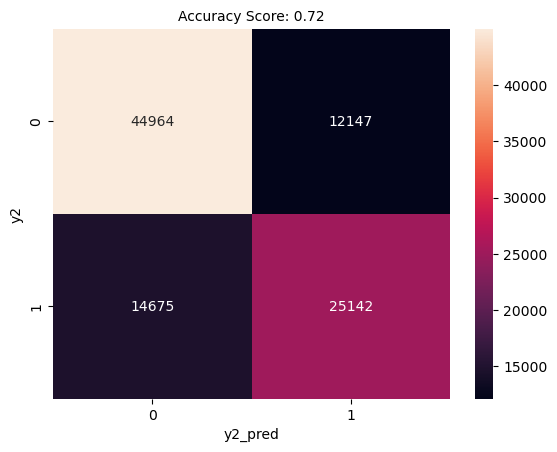

In [67]:
# Confusion Matrix

def plot_confusion_matrix(y2, y2_pred):
    acc = round(accuracy_score(y2, y2_pred), 2)
    cm = confusion_matrix(y2, y2_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y2_pred')
    plt.ylabel('y2')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y2_test, y2_pred)

## XGBOOST CLASSIFIER

In [68]:
xgbClass = XGBClassifier()
xgb_model_2 = xgbClass.fit(X2_train_scaled, y2_train)

In [69]:
#Prediction
y2_pred_xgb = xgb_model_2.predict(X2_test_scaled)
y2_pred_xgb[0:10]

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [70]:
# Cross validation method to explain success of model
cv_results_xgb_2 = cross_validate(xgb_model_2,
                            X2_train_scaled, y2_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_xgb_2

{'fit_time': array([1.21809697, 1.17452264, 1.26852322, 1.21122026, 1.18320823]),
 'score_time': array([0.14243245, 0.16123199, 0.16444087, 0.16110945, 0.18705392]),
 'test_accuracy': array([0.74797161, 0.74553976, 0.7453629 , 0.74352796, 0.74598192]),
 'train_accuracy': array([0.76098755, 0.76278934, 0.76265116, 0.76194924, 0.76176132]),
 'test_precision': array([0.69650608, 0.68945188, 0.69219981, 0.69112619, 0.69297157]),
 'train_precision': array([0.71257599, 0.7133576 , 0.71341636, 0.71302807, 0.71205444]),
 'test_recall': array([0.68858614, 0.69625617, 0.68826432, 0.68300794, 0.68903191]),
 'train_recall': array([0.70415812, 0.70965579, 0.70895853, 0.70701423, 0.70851212]),
 'test_f1': array([0.69252347, 0.69283732, 0.69022645, 0.68704308, 0.69099613]),
 'train_f1': array([0.70834204, 0.71150188, 0.71118046, 0.71000842, 0.71027887]),
 'test_roc_auc': array([0.82561435, 0.8222006 , 0.82413034, 0.81941906, 0.82301515]),
 'train_roc_auc': array([0.84233167, 0.84481545, 0.84442956, 0

In [71]:
report_xgb_2 = metrics.classification_report(y2_test, y2_pred_xgb)
print(report_xgb_2)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     57111
           1       0.70      0.67      0.68     39817

    accuracy                           0.75     96928
   macro avg       0.74      0.73      0.74     96928
weighted avg       0.74      0.75      0.74     96928



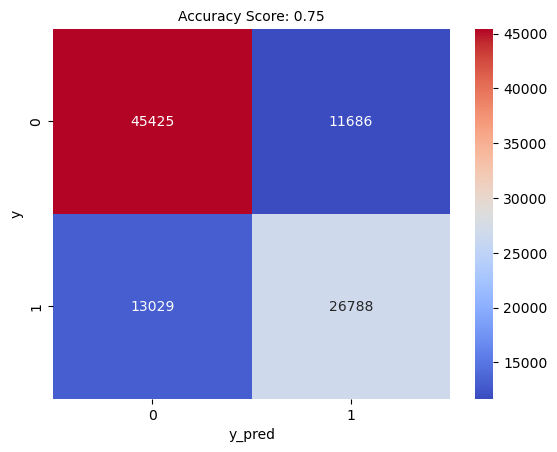

In [72]:
def plot_confusion_matrix(y2, y2_pred_xgb):
    acc = round(accuracy_score(y2, y2_pred_xgb), 2)
    cm = confusion_matrix(y2, y2_pred_xgb)
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y2_test, y2_pred_xgb)

## MODELS EVALUATION METRICS FOR DATASET 2 WITH BAR GRAPH

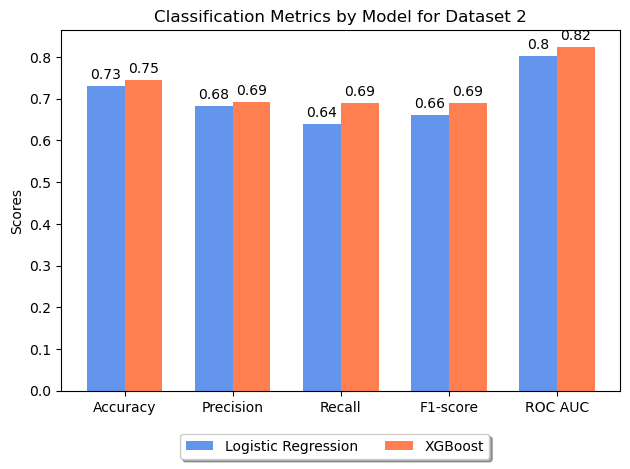

In [73]:
# Logistic Regression Metrics and Xgboost Evaluation Metrics
log_metrics = np.array([cv_results_log_2['test_accuracy'].mean(),
                        cv_results_log_2['test_precision'].mean(),
                        cv_results_log_2['test_recall'].mean(),
                        cv_results_log_2['test_f1'].mean(),
                        cv_results_log_2['test_roc_auc'].mean()])

xgb_metrics = np.array([cv_results_xgb_2['test_accuracy'].mean(),
                        cv_results_xgb_2['test_precision'].mean(),
                        cv_results_xgb_2['test_recall'].mean(),
                        cv_results_xgb_2['test_f1'].mean(),
                        cv_results_xgb_2['test_roc_auc'].mean()])

# Evaluation Metric Names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

# Colors
log_color = 'cornflowerblue'
xgb_color = 'coral'

# Bar Graph
x = np.arange(len(metric_names))  
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, log_metrics, width, label='Logistic Regression', color=log_color)
bars2 = ax.bar(x + width/2, xgb_metrics, width, label='XGBoost', color=xgb_color)

# Labels
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Model for Dataset 2')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Legend Location
ax.legend(loc='upper left', bbox_to_anchor=(0.2, -0.1), shadow=True, ncol=2)

# To add metric results to all bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

## DATASET 3: DIABETES 130 US HOSPITALS FOR YEAR 1999-2008

In [74]:
df3 = pd.read_csv("diabetes+130-us+hospitals+for+years+1999-2008.csv")

In [75]:
df3.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [76]:
df3.shape

(101766, 50)

In [77]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [78]:
df3.readmitted = [1 if each=='<30' else 0 for each in df3.readmitted]

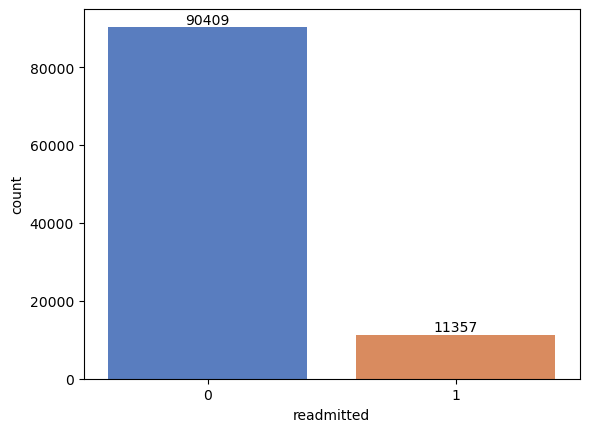

In [79]:
# Target Variable Class Counts

class_counts = df3["readmitted"].value_counts()             
ax = sns.countplot(x="readmitted", data=df3, palette="muted") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

In [80]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


## DATA CLEANING

In [81]:
# Missing Value Check

df3.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [82]:
# Filling missing values with "?"

df3["max_glu_serum"]= df3["max_glu_serum"].fillna("?")
df3["A1Cresult"]= df3["A1Cresult"].fillna("?")

In [83]:
# Duplicated Value Check

df3.duplicated().value_counts()

False    101766
Name: count, dtype: int64

In [84]:
# NOTE: 

# patient_nbr	
# encounter_id
# weight           98569 value are ? 
# payer_code       40256 value are  ?
# medical_specialty   49949 value are ? 
# examide          all values are no 
# Citoglipton     all values are no 

In [85]:
drop_list = ["examide", "citoglipton", "weight", "encounter_id", "patient_nbr", "payer_code", "medical_specialty"]

df3 = df3.drop(drop_list, axis=1)
df3.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [86]:
# Removing Unknown/Invalid 3 rows from gender column

df3.drop(df3[df3["gender"] == "Unknown/Invalid"].index, inplace=True)

In [87]:
# Removing ? values from race column and filling them with mode

df3["race"].replace("?", np.nan, inplace=True)

mode_value = df3["race"].mode()[0]
df3["race"].fillna(mode_value, inplace=True)

In [88]:
# Outlier Check

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    '''
    Outlier Thresholds function define lower and upper limits to detect outlier values
    in a given DataFrame. Quartile1 (q1) and Quartile3(q2) can be changed by the user.
    It returns lower and upper limits based on the interquartile method (IQR).
    '''
    if not pd.api.types.is_numeric_dtype(dataframe[col_name]):
        print(f"Warning: {col_name} is not a numeric column.")
        return None, None
    
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name): 
    '''
    Check Outlier function detects outlier values in a given DataFrame.
    It shows True if there are outlier values in a column, otherwise not.
    '''
    if not pd.api.types.is_numeric_dtype(dataframe[col_name]):
        print(f"Warning: {col_name} is not a numeric column.")
        return False
    
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in df3.columns:
    print(col, check_outlier(df3, col))

race False
gender False
age False
admission_type_id False
discharge_disposition_id False
admission_source_id False
time_in_hospital False
num_lab_procedures False
num_procedures False
num_medications True
number_outpatient True
number_emergency True
number_inpatient True
diag_1 False
diag_2 False
diag_3 False
number_diagnoses False
max_glu_serum False
A1Cresult False
metformin False
repaglinide False
nateglinide False
chlorpropamide False
glimepiride False
acetohexamide False
glipizide False
glyburide False
tolbutamide False
pioglitazone False
rosiglitazone False
acarbose False
miglitol False
troglitazone False
tolazamide False
insulin False
glyburide-metformin False
glipizide-metformin False
glimepiride-pioglitazone False
metformin-rosiglitazone False
metformin-pioglitazone False
change False
diabetesMed False
readmitted False


In [89]:
# Replacing the outliers with up and low value

def replace_with_thresholds(dataframe, variable):
    '''
    Replace_with_thresholds function replace the outliers with up and low value.
    '''
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

    
replace_with_thresholds(df3, "num_medications")
replace_with_thresholds(df3, "number_outpatient")
replace_with_thresholds(df3, "number_emergency")
replace_with_thresholds(df3, "number_inpatient")

## FEATURE ENGINEERING

In [90]:
# diag_1, diag_2, diag_3

diag_list = ["diag_1", "diag_2", "diag_3"]

for col in diag_list:
    df3[col].fillna('NaN', inplace=True)

In [91]:
def transform_function(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def Transform_to_Category(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'

    return category

In [92]:
# Removing "?" values from diag_1, 2, and 3

df3.drop(df3[df3["diag_1"] == "?"].index, inplace=True)
df3.drop(df3[df3["diag_2"] == "?"].index, inplace=True)
df3.drop(df3[df3["diag_3"] == "?"].index, inplace=True)

In [93]:
for col in diag_list:
    df3[col] = df3[col].apply(transform_function)
    df3[col] = df3[col].astype(float)  


In [94]:
for col in diag_list:
    df3[col] = df3[col].apply(Transform_to_Category)

In [95]:
# Label Encoding for Categoric Variables

categories = ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
              'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
              'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
              'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
              'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 
              'diabetesMed']

label_encoder = LabelEncoder()


for col in categories:
    df3[col] = label_encoder.fit_transform(df3[col])

In [96]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100241 entries, 1 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   race                      100241 non-null  int32  
 1   gender                    100241 non-null  int32  
 2   age                       100241 non-null  int32  
 3   admission_type_id         100241 non-null  int64  
 4   discharge_disposition_id  100241 non-null  int64  
 5   admission_source_id       100241 non-null  int64  
 6   time_in_hospital          100241 non-null  int64  
 7   num_lab_procedures        100241 non-null  int64  
 8   num_procedures            100241 non-null  int64  
 9   num_medications           100241 non-null  float64
 10  number_outpatient         100241 non-null  int64  
 11  number_emergency          100241 non-null  float64
 12  number_inpatient          100241 non-null  float64
 13  diag_1                    100241 non-null  int32 

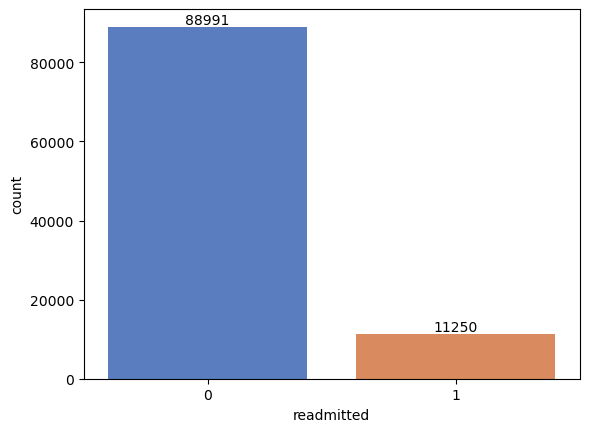

In [97]:
# Target Variable Class Counts

class_counts = df3["readmitted"].value_counts()             
ax = sns.countplot(x="readmitted", data=df3, palette="muted") 
for i, count in enumerate(class_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

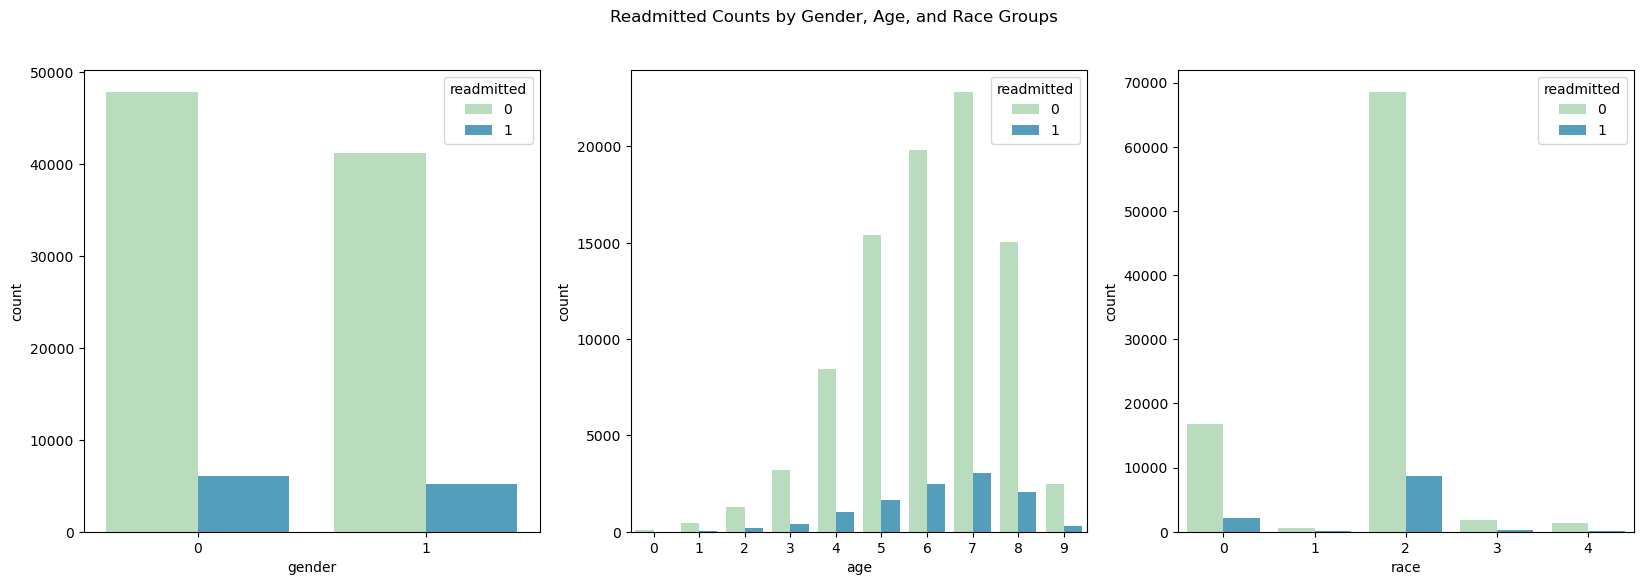

In [98]:
mylist = ["gender","age","race"]

fig, ax = plt.subplots(1, len(mylist), figsize=(20, 6))
count = 0
for i in mylist:
    sns.countplot(x=i, hue="readmitted", data=df3, palette="GnBu", ax=ax[count])
    count += 1
    
plt.suptitle("Readmitted Counts by Gender, Age, and Race Groups", fontsize=12)
plt.show()

In [99]:
# Saving clean df3 to csv file

df3.to_csv('diabetes+130-us+hospitals+for+years+1999-2008_cleaned.csv')  

## DATA PREPARATION 

## Over Sampling &  Train-Test Split

In [100]:
X3 = df3.iloc[:, 0:42]  # independent variables
y3 = df3["readmitted"]  # target variable

In [101]:
oversample = RandomOverSampler(sampling_strategy=0.7)
X3_over, y3_over = oversample.fit_resample(X3, y3)

In [102]:
print(Counter(y3_over))

Counter({0: 88991, 1: 62293})


In [103]:
# Splitting data 70% training, 30% testing
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_over, y3_over, 
                                                    test_size=0.3, random_state=123)

# Size of train and test data
print("X3_train shape:", X3_train.shape)
print("X3_test shape:", X3_test.shape)
print("y3_train shape:", y3_train.shape)
print("y3_test shape:", y3_test.shape)

X3_train shape: (105898, 42)
X3_test shape: (45386, 42)
y3_train shape: (105898,)
y3_test shape: (45386,)


In [104]:
rb = RobustScaler()

X3_train_scaled = rb.fit_transform(X3_train)
X3_test_scaled = rb.fit_transform(X3_test)

## LOGISTIC REGRESSION

In [105]:
log_model_3 = LogisticRegression(max_iter=400).fit(X3_train_scaled, y3_train)           

log_model_3.intercept_             
log_model_3.coef_                  


array([[-0.00954137,  0.0104355 ,  0.07432535, -0.01321596,  0.09619   ,
        -0.02249058,  0.08579806,  0.00553495, -0.07196256,  0.04480106,
        -0.00464586,  0.14705595,  0.2908676 , -0.13682297,  0.03612227,
         0.08520637,  0.11184483, -0.0172695 ,  0.0348093 , -0.15227314,
         0.0590803 , -0.07995814, -0.74796386, -0.10435484, -0.37554484,
        -0.02730627, -0.05348111, -0.78058002, -0.10321858, -0.04305146,
        -0.40352097, -0.76396296, -0.80477901, -0.39648485, -0.03574036,
        -0.15424237,  0.2360803 , -0.32451665, -0.30865388, -0.26297803,
        -0.0517875 ,  0.21392753]])

In [106]:
# Prediction
y3_pred= log_model_3.predict(X3_test_scaled)        

y3_pred[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [107]:
cv_results_log_3 = cross_validate(log_model_3,
                            X3_train_scaled, y3_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_log_3

{'fit_time': array([2.028404  , 2.80133963, 1.82096887, 2.28303456, 2.30769324]),
 'score_time': array([0.05379581, 0.05457425, 0.05021167, 0.06823206, 0.0530107 ]),
 'test_accuracy': array([0.62615675, 0.62152975, 0.62549575, 0.6238727 , 0.62000094]),
 'train_accuracy': array([0.62318516, 0.62345664, 0.62358649, 0.6241221 , 0.62398045]),
 'test_precision': array([0.60498221, 0.59484106, 0.6037302 , 0.59778505, 0.58590853]),
 'train_precision': array([0.59665463, 0.59757491, 0.59853082, 0.59839105, 0.59941353]),
 'test_recall': array([0.27218664, 0.26109332, 0.27024245, 0.27164589, 0.271074  ]),
 'train_recall': array([0.26925716, 0.26914279, 0.26791331, 0.27222302, 0.26884918]),
 'test_f1': array([0.37545354, 0.36289938, 0.37336072, 0.37354514, 0.37065999]),
 'train_f1': array([0.37106212, 0.37113118, 0.37014359, 0.37420902, 0.37120524]),
 'test_roc_auc': array([0.64267033, 0.63981847, 0.64519335, 0.63745625, 0.64119491]),
 'train_roc_auc': array([0.64182138, 0.64301432, 0.64172253, 0

In [108]:
report_log_3 = metrics.classification_report(y3_test, y3_pred)
print(report_log_3)

              precision    recall  f1-score   support

           0       0.63      0.87      0.73     26811
           1       0.60      0.27      0.37     18575

    accuracy                           0.63     45386
   macro avg       0.62      0.57      0.55     45386
weighted avg       0.62      0.63      0.59     45386



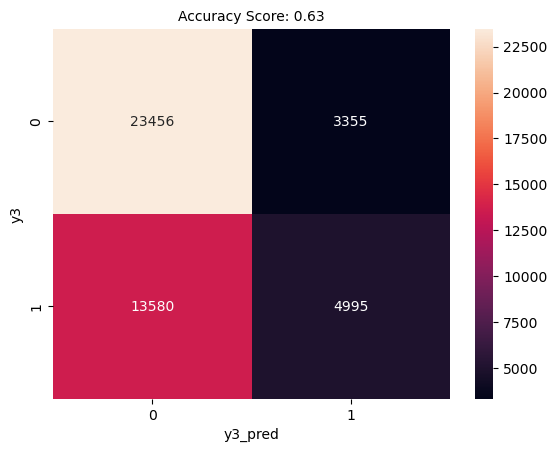

In [109]:
# Confusion Matrix

def plot_confusion_matrix(y3, y3_pred):
    acc = round(accuracy_score(y3, y3_pred), 2)
    cm = confusion_matrix(y3, y3_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y3_pred')
    plt.ylabel('y3')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y3_test, y3_pred)

## XGBOOST CLASSIFIER

In [110]:
xgbClass = XGBClassifier()
xgb_model_3 = xgbClass.fit(X3_train_scaled, y3_train)

In [111]:
#Prediction
y3_pred_xgb = xgb_model_3.predict(X3_test_scaled)
y3_pred_xgb[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [112]:
# Cross validation method to explain success of model
cv_results_xgb_3 = cross_validate(xgb_model_3,
                            X3_train_scaled, y3_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
                           return_train_score=True)

cv_results_xgb_3

{'fit_time': array([0.79184151, 1.25543594, 0.64124727, 0.52588391, 0.49698377]),
 'score_time': array([0.10085416, 0.09993052, 0.07958436, 0.07957411, 0.11071491]),
 'test_accuracy': array([0.72223796, 0.71260623, 0.7128423 , 0.71051513, 0.71315926]),
 'train_accuracy': array([0.75987393, 0.75692297, 0.75637999, 0.75692584, 0.76142306]),
 'test_precision': array([0.71208302, 0.70360153, 0.69671889, 0.68949507, 0.69583089]),
 'train_precision': array([0.771276  , 0.76719557, 0.76449315, 0.76476436, 0.77126897]),
 'test_recall': array([0.54929094, 0.52504575, 0.53911253, 0.54352053, 0.542148  ]),
 'train_recall': array([0.59469892, 0.59032424, 0.59235432, 0.59388134, 0.60005718]),
 'test_f1': array([0.62018206, 0.60134914, 0.60786589, 0.60786697, 0.60945034]),
 'train_f1': array([0.67157456, 0.66723762, 0.66750439, 0.66857649, 0.67497507]),
 'test_roc_auc': array([0.79043558, 0.78278021, 0.78448047, 0.78190916, 0.77992688]),
 'train_roc_auc': array([0.84355851, 0.84053824, 0.84059585, 0

In [113]:
report_xgb_3 = metrics.classification_report(y3_test, y3_pred_xgb)
print(report_xgb_3)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77     26811
           1       0.69      0.51      0.59     18575

    accuracy                           0.71     45386
   macro avg       0.70      0.68      0.68     45386
weighted avg       0.70      0.71      0.70     45386



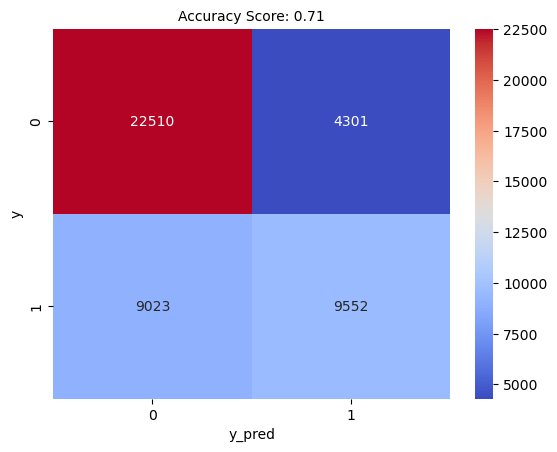

In [114]:
def plot_confusion_matrix(y3, y3_pred_xgb):
    acc = round(accuracy_score(y3, y3_pred_xgb), 2)
    cm = confusion_matrix(y3, y3_pred_xgb)
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y3_test, y3_pred_xgb)

## MODELS EVALUATION METRICS FOR DATASET 3 WITH BAR GRAPH

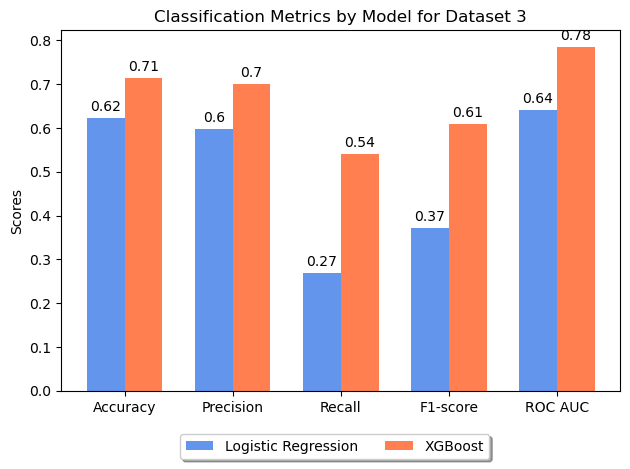

In [115]:
# Logistic Regression Metrics and Xgboost Evaluation Metrics
log_metrics = np.array([cv_results_log_3['test_accuracy'].mean(),
                        cv_results_log_3['test_precision'].mean(),
                        cv_results_log_3['test_recall'].mean(),
                        cv_results_log_3['test_f1'].mean(),
                        cv_results_log_3['test_roc_auc'].mean()])

xgb_metrics = np.array([cv_results_xgb_3['test_accuracy'].mean(),
                        cv_results_xgb_3['test_precision'].mean(),
                        cv_results_xgb_3['test_recall'].mean(),
                        cv_results_xgb_3['test_f1'].mean(),
                        cv_results_xgb_3['test_roc_auc'].mean()])

# Evaluation Metric Names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

# Colors
log_color = 'cornflowerblue'
xgb_color = 'coral'

# Bar Graph
x = np.arange(len(metric_names))  
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, log_metrics, width, label='Logistic Regression', color=log_color)
bars2 = ax.bar(x + width/2, xgb_metrics, width, label='XGBoost', color=xgb_color)

# Labels
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Model for Dataset 3')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Legend Location
ax.legend(loc='upper left', bbox_to_anchor=(0.2, -0.1), shadow=True, ncol=2)

# To add metric results to all bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()